### HDFS 의 DATA 를 LOAD 해서 다른 의미를 갖는 가공 데이터 처리하는 프로그램
- 이 프로그램 내 처리 코드를 DW 에 저장할 때 사용하거나 DM에 저장할 때 사용한다.
- 인구대비 코로나 발생현황
- 코로나 발생현황과 백신과의 관계
- 공용시설 대비 코로나 발생현황

In [10]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [11]:
# 나눔폰트 사용을 위한 터미널 명령어이다. - aws 는 ubuntu sudo apt-get 명령어 사용
# matplotlib 한글 꺠짐 방지
# apt-get update
# apt-get install fonts-nanum* 
# apt-get install fontconfig
# fc-cache -fv  # font 캐시 날리기
# rm -rf /home/hy1/.cache/matplotlib/  #matplotliob 폰트 캐시 날리기

In [12]:
from datetime import date, datetime
from pyspark.sql.types import *
from pyspark.sql.functions import *
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt #그래프 패키지 모듈 등록
%matplotlib inline 

In [13]:
from hdfs import InsecureClient

### DW에 있는 data 사용하기 위한 hdfs 클라이언트 객체 생성

In [14]:
client = InsecureClient('http://localhost:9870', user='Lab09')
# aws: user = 'Lab09'

### 한글 폰트 적용

In [15]:
import platform

from matplotlib import font_manager, rc
plt.rcParams['axes.unicode_minus'] = False

if platform.system() == 'Darwin':  # 맥OS 
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':  # 윈도우
    path = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    rc('font', family='NanumGothic') # 나눔 폰트 사용

## Transform

In [16]:
# 기준일 생성 함수
def cal_std_day(before_day) :
    x = dt.datetime.now()-dt.timedelta(before_day)
    year = x.year
    month = x.month if x.month >=10 else '0'+str(x.month)
    day = x.day if x.day >= 10 else '0'+str(x.day)
    return str(year)+'-'+str(month)+'-'+str(day)

### 1. 지역별 단위면적(km) 당 인구수 와 코로나 확진자수를 가공한 data 생성

In [17]:
# 지역의 면적 및 인구 정보 데이터 불러오기
area = spark.read.csv('/corona_data/loc/sido_area.csv', encoding='CP949', header=True)
area.show()

+----+------+-----+
| loc|  area|ratio|
+----+------+-----+
|서울|  605 |  0.6|
|부산|  770 |  0.8|
|대구|  883 |  0.9|
|인천| 1065 |  1.1|
|광주|  501 |  0.5|
|대전|  540 |  0.5|
|울산| 1062 |  1.1|
|세종|  465 |  0.5|
|경기|10195 | 10.2|
|강원|16830 | 16.8|
|충북| 7407 |  7.4|
|충남| 8246 |  8.2|
|전북| 8070 |  8.0|
|전남|12348 | 12.3|
|경북|19034 | 19.0|
|경남|10541 | 10.5|
|제주| 1850 |  1.8|
+----+------+-----+



In [18]:
# 지역별 인구 정보 데이터 불러오기
popu = spark.read.csv('/corona_data/loc/sido_population.csv',encoding='CP949',header=True)
popu.show()

+----+---------+---------+---------+
| loc|    total|     male|   female|
+----+---------+---------+---------+
|전국|52739009 |26360035 |26378974 |
|서울| 9736027 | 4721977 | 5014050 |
|부산| 3396109 | 1663619 | 1732490 |
|대구| 2412642 | 1189901 | 1222741 |
|인천| 3014739 | 1513277 | 1501462 |
|광주| 1462545 |  724178 |  738367 |
|대전| 1469543 |  732593 |  736950 |
|울산| 1138419 |  586031 |  552388 |
|세종|  376779 |  188619 |  188160 |
|경기|13925862 | 7038296 | 6887566 |
|강원| 1555876 |  783743 |  772133 |
|충북| 1633472 |  832743 |  800729 |
|충남| 2181835 | 1120429 | 1061406 |
|전북| 1817186 |  905672 |  911514 |
|전남| 1865459 |  943018 |  922441 |
|경북| 2677709 | 1355128 | 1322581 |
|경남| 3377331 | 1709989 | 1667342 |
|제주|  697476 |  350822 |  346654 |
+----+---------+---------+---------+



- 면적과 인구관련 data 는 자주 변하지 않는 data 임
    - 면적은 거의 불변/인구 통계 시점 - 3 ~ 4년
    - 자동화에서 제외
    - dw db에 table 로 저장해놓는다.

### 단위면적당 인구수 data 생성
- 면적data와 인구data join 후 가공 df 생성

In [19]:
area_pop = area.join(popu, on='loc')
area_pop.show()

+----+------+-----+---------+--------+--------+
| loc|  area|ratio|    total|    male|  female|
+----+------+-----+---------+--------+--------+
|서울|  605 |  0.6| 9736027 |4721977 |5014050 |
|부산|  770 |  0.8| 3396109 |1663619 |1732490 |
|대구|  883 |  0.9| 2412642 |1189901 |1222741 |
|인천| 1065 |  1.1| 3014739 |1513277 |1501462 |
|광주|  501 |  0.5| 1462545 | 724178 | 738367 |
|대전|  540 |  0.5| 1469543 | 732593 | 736950 |
|울산| 1062 |  1.1| 1138419 | 586031 | 552388 |
|세종|  465 |  0.5|  376779 | 188619 | 188160 |
|경기|10195 | 10.2|13925862 |7038296 |6887566 |
|강원|16830 | 16.8| 1555876 | 783743 | 772133 |
|충북| 7407 |  7.4| 1633472 | 832743 | 800729 |
|충남| 8246 |  8.2| 2181835 |1120429 |1061406 |
|전북| 8070 |  8.0| 1817186 | 905672 | 911514 |
|전남|12348 | 12.3| 1865459 | 943018 | 922441 |
|경북|19034 | 19.0| 2677709 |1355128 |1322581 |
|경남|10541 | 10.5| 3377331 |1709989 |1667342 |
|제주| 1850 |  1.8|  697476 | 350822 | 346654 |
+----+------+-----+---------+--------+--------+



### area_pop : popu_density 컬럼 추가 생성
- 단위면적당 인구수 정보를 갖고있는 가공 df 생성
- 가공 df 고 연산을 통해 생성되었으므로 dm db에 저장한다.

In [20]:
area_pop = area_pop.select(area_pop.loc,
                (ceil(area_pop.total/area_pop.area)).alias('popu_density'))
area_pop.show()

+----+------------+
| loc|popu_density|
+----+------------+
|서울|       16093|
|부산|        4411|
|대구|        2733|
|인천|        2831|
|광주|        2920|
|대전|        2722|
|울산|        1072|
|세종|         811|
|경기|        1366|
|강원|          93|
|충북|         221|
|충남|         265|
|전북|         226|
|전남|         152|
|경북|         141|
|경남|         321|
|제주|         378|
+----+------------+



### 지역별 코로나 환자 데이터와의 관계
- api data 는 지역별 누적 코로나 환자 데이터가 있음 : qurRate 를 활용

In [21]:
# 코로나 환자 데이터 가져오기 : api data
file_name = 'hdfs://localhost:9000/corona_data/patient/corona_patient_' + cal_std_day(365) + '.json'

# file_name
tmp = spark.read.json(file_name, encoding='UTF-8') # spark dataframe 형태로 들어온다

In [22]:
tmp.columns

['items', 'numOfRows', 'pageNo', 'resultCode', 'resultMsg', 'totalCount']

In [23]:
tmp.select('items').count()

1

In [24]:
tmp.show()

+--------------------+---------+------+----------+--------------+----------+
|               items|numOfRows|pageNo|resultCode|     resultMsg|totalCount|
+--------------------+---------+------+----------+--------------+----------+
|[{31882, 28772196...|      500|     1|        00|NORMAL SERVICE|        19|
+--------------------+---------+------+----------+--------------+----------+



In [25]:
# items 컬럼 데이터만 추출, 1개이므로 first() 함수 연결해서 추출
tmp_fin = tmp.select('items').first()
tmp_fin

Row(items=[Row(deathCnt='31882', defCnt='28772196', gubun='합계', gubunCn='合计', gubunEn='Total', incDec='87578', isolClearCnt='0', isolIngCnt='0', localOccCnt='87512', overFlowCnt='66', qurRate='55718', stdDay='2022-12-27'), Row(deathCnt='767', defCnt='841430', gubun='광주', gubunCn='光州', gubunEn='Gwangju', incDec='1735', isolClearCnt='0', isolIngCnt='0', localOccCnt='1735', overFlowCnt='0', qurRate='58367', stdDay='2022-12-27'), Row(deathCnt='878', defCnt='840729', gubun='대전', gubunCn='大田', gubunEn='Daejeon', incDec='2563', isolClearCnt='0', isolIngCnt='0', localOccCnt='2563', overFlowCnt='0', qurRate='57891', stdDay='2022-12-27'), Row(deathCnt='7921', defCnt='7789934', gubun='경기', gubunCn='京畿', gubunEn='Gyeonggi-do', incDec='24362', isolClearCnt='0', isolIngCnt='0', localOccCnt='24356', overFlowCnt='6', qurRate='57425', stdDay='2022-12-27'), Row(deathCnt='2662', defCnt='1696702', gubun='부산', gubunCn='釜山', gubunEn='Busan', incDec='6826', isolClearCnt='0', isolIngCnt='0', localOccCnt='6824

In [26]:
# tmp_fin['items']

In [27]:
co_patient = spark.createDataFrame(tmp_fin['items'])
co_patient.show() ## 2022-12-27 의 코로나 발생 현황 json -> dataframe 해놓은 것.

+--------+--------+-----+-------+-----------------+------+------------+----------+-----------+-----------+-------+----------+
|deathCnt|  defCnt|gubun|gubunCn|          gubunEn|incDec|isolClearCnt|isolIngCnt|localOccCnt|overFlowCnt|qurRate|    stdDay|
+--------+--------+-----+-------+-----------------+------+------------+----------+-----------+-----------+-------+----------+
|   31882|28772196| 합계|   合计|            Total| 87578|           0|         0|      87512|         66|  55718|2022-12-27|
|     767|  841430| 광주|   光州|          Gwangju|  1735|           0|         0|       1735|          0|  58367|2022-12-27|
|     878|  840729| 대전|   大田|          Daejeon|  2563|           0|         0|       2563|          0|  57891|2022-12-27|
|    7921| 7789934| 경기|   京畿|      Gyeonggi-do| 24362|           0|         0|      24356|          6|  57425|2022-12-27|
|    2662| 1696702| 부산|   釜山|            Busan|  6826|           0|         0|       6824|          2|  50642|2022-12-27|
|    1841| 1

- 일간으로 수집해야 하는 data
    - 각 부서에서 사용하는 data 이므로 dw-dm 까지 저장되어야하는 data
    - 위 df 는 중요컬럼만 추출해서 dw db에 저장하겠다.
    - dm 저장은 다른 데이터와 연결 가공해서 저장

In [28]:
tmp_fin = co_patient.select(co_patient.gubun.alias('loc'), co_patient.qurRate) # 지역별 코로나 환자 누적 발생 현황
tmp_fin.show()

+----+-------+
| loc|qurRate|
+----+-------+
|합계|  55718|
|광주|  58367|
|대전|  57891|
|경기|  57425|
|부산|  50642|
|대구|  52711|
|충남|  54823|
|검역|      -|
|서울|  59003|
|경남|  51700|
|강원|  55405|
|인천|  56617|
|울산|  54480|
|전남|  51184|
|경북|  50017|
|충북|  56550|
|제주|  53626|
|세종|  61309|
|전북|  53978|
+----+-------+



1. area_pop: 각 지역의 면적대비 인구
2. tmp_fin : 각 지역의 코로나 현황 data

In [29]:
co_rate = area_pop.join(tmp_fin, on = 'loc').orderBy(col('loc'))
co_rate.show(co_rate.count())
co_rate.printSchema()

+----+------------+-------+
| loc|popu_density|qurRate|
+----+------------+-------+
|강원|          93|  55405|
|경기|        1366|  57425|
|경남|         321|  51700|
|경북|         141|  50017|
|광주|        2920|  58367|
|대구|        2733|  52711|
|대전|        2722|  57891|
|부산|        4411|  50642|
|서울|       16093|  59003|
|세종|         811|  61309|
|울산|        1072|  54480|
|인천|        2831|  56617|
|전남|         152|  51184|
|전북|         226|  53978|
|제주|         378|  53626|
|충남|         265|  54823|
|충북|         221|  56550|
+----+------------+-------+

root
 |-- loc: string (nullable = true)
 |-- popu_density: long (nullable = true)
 |-- qurRate: string (nullable = true)



In [30]:
### co_rate spark df 를 pd df 로 변환 
pd_corate = co_rate.toPandas()
pd_corate['qurRate'] = pd_corate['qurRate'].astype(int) # 정수형으로 변환해준다.

<AxesSubplot:xlabel='popu_density', ylabel='qurRate'>

findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.


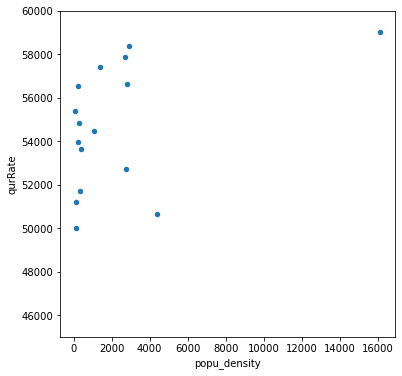

In [31]:
pd_corate.plot(kind = 'scatter',
              x = 'popu_density',
              y =  'qurRate',
              # xlim = (0, 8000),
              ylim = (45000, 60000),
              figsize = (6, 6)
              )

- 1.인구데이터와 코로나 확진자 데이터를 결합해서 중요피쳐만 추출 - dW의 db에 저장
- 2.인구데이터와 코로나 확진자 데이터를 결합해서 단위 면적당 인구수 와 지역별 누적 확진자 수 컬럼만 갖고 있는 data - dm의 db에 저장

## 백신 접종 완료자와 코로나 확진자 수의 상관관계를 알아보기 위한 data 준비하기
- 백신 접종은 인구대비 비율을 사용한다.

In [36]:
# 인구 data
popu = spark.read.csv('/corona_data/loc/sido_population.csv',encoding='CP949',header=True)

# 코로나 확진자 data
file_name = 'hdfs://localhost:9000/corona_data/patient/corona_patient_' + cal_std_day(365) + '.json'
tmp = spark.read.json(file_name, encoding='UTF-8')
tmp_fin = tmp.select('items').first()
co_patient = spark.createDataFrame(tmp_fin['items'])

# 백신관련 data
file_name = '/corona_data/vaccine/corona_vaccine_'+ cal_std_day(365) +'.json'
vaccine = spark.read.json(file_name)
vaccine_data = spark.createDataFrame(vaccine.select('data').first()['data'])
# vaccine_data.show()

In [37]:
# 백신 data 와 인구 data
pop_vaccine = vaccine_data.join(popu, on = 'loc').select('loc', ceil(vaccine_data.v3/popu.total * 100).alias('vaccine_pop_rate'))
# pop.vaccine.show()
patient_tmp = co_patient.select(co_patient.gubun.alias('loc'), co_patient.qurRate)
# patient_tmp.show()
co_vaccine_patient = pop_vaccine.join(patient_tmp, on = 'loc')
co_vaccine_patient.show()

+----+----------------+-------+
| loc|vaccine_pop_rate|qurRate|
+----+----------------+-------+
|강원|              69|  55405|
|경기|              63|  57425|
|경남|              64|  51700|
|경북|              65|  50017|
|광주|              67|  58367|
|대구|              59|  52711|
|대전|              62|  57891|
|부산|              64|  50642|
|서울|              63|  59003|
|세종|              57|  61309|
|울산|              64|  54480|
|인천|              64|  56617|
|전남|              74|  51184|
|전북|              71|  53978|
|제주|              63|  53626|
|충남|              68|  54823|
|충북|              68|  56550|
+----+----------------+-------+



<AxesSubplot:xlabel='vaccine_pop_rate', ylabel='qurRate'>

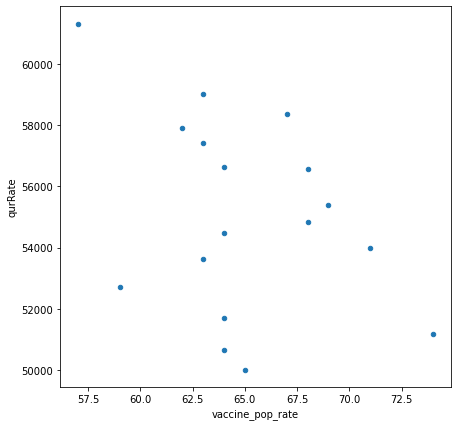

In [40]:
pd_vac_pa = co_vaccine_patient.toPandas()

pd_vac_pa['qurRate'] = pd_vac_pa['qurRate'].astype(int)

pd_vac_pa.plot(kind = 'scatter', x = 'vaccine_pop_rate', y = 'qurRate', figsize = (7,7))

- vaccine df 는 dw에 저장
- 인구대비 정종률과 코로나 dm db에 넣겠다.

- 1. 인구 대비 접종률을 계산한 data : dw db
- 2. 1번 데이터와 코로나 확진자수 데이터가 결합한 data : dm db

### 지역별 다중 이용시설과 코로나 확진자수의 상관관계
- 지역별 다중이용시설 data와 인구와의 관계
- 코로나 확진자수

In [41]:
# 인구
# 코로나 확진자

# 인구 data
popu = spark.read.csv('/corona_data/loc/sido_population.csv',encoding='CP949',header=True)
# 코로나 확진자 data
file_name = 'hdfs://localhost:9000/corona_data/patient/corona_patient_' + cal_std_day(365) + '.json'
tmp = spark.read.json(file_name, encoding='UTF-8')
tmp_fin = tmp.select('items').first()
co_patient = spark.createDataFrame(tmp_fin['items'])

# 다중이용시설 data
facil = spark.read.csv('/corona_data/loc/전국다중이용시설.csv',encoding='CP949',header=True)
# facil.show()

In [42]:
# 다중이용시설data(facil)를 광역시도(광역)별 개수를 세고 해당 데이터를 활용함.
fac_cnt = facil.groupby(col('광역').alias('loc')).agg(count('*').alias('fac_cnt'))
# fac_cnt.show()

# 지역 + 인구 10만명당 다중이용시설의 개수를 구해준다.
pop_fac_rate = popu.join(fac_cnt, on = 'loc')
# pop_fac_rate.show()

# 10만명 기준이기 때문에 10만명당 개수를 파악해준다.
pop_fac_rate = pop_fac_rate.select('loc', ceil(fac_cnt.fac_cnt/popu.total*100000).alias('fac_popu'))
# pop_fac_rate.show()

# 코로나 확진자 수 + 누적확진자 수 를 합쳐서 나타내준다.
tmp = co_patient.select(co_patient.gubun.alias('loc'), 'qurRate')
pop_fac_co_rate = pop_fac_rate.join(tmp, on = 'loc')
pop_fac_co_rate.show()

+----+--------+-------+
| loc|fac_popu|qurRate|
+----+--------+-------+
|강원|      38|  55405|
|경기|      46|  57425|
|경남|      41|  51700|
|경북|      36|  50017|
|광주|      51|  58367|
|대구|      43|  52711|
|대전|      53|  57891|
|부산|      44|  50642|
|서울|      54|  59003|
|세종|      65|  61309|
|울산|      38|  54480|
|인천|      46|  56617|
|전남|      45|  51184|
|전북|      42|  53978|
|제주|      45|  53626|
|충남|      38|  54823|
|충북|      38|  56550|
+----+--------+-------+



In [43]:
# pd df로 변환해준다.
pd_fac = pop_fac_co_rate.toPandas()

<AxesSubplot:xlabel='fac_popu', ylabel='qurRate'>

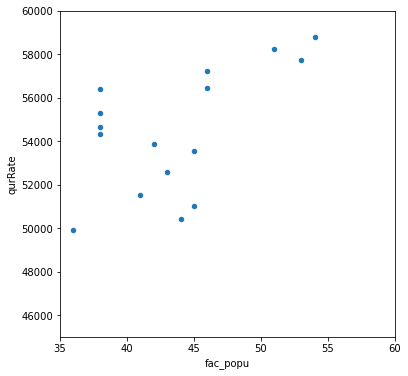

In [134]:
pd_fac['qurRate'] = pd_fac['qurRate'].astype(int)
pd_fac.plot(kind = 'scatter', x = 'fac_popu', y = 'qurRate', ylim = (45000, 60000), xlim = (35, 60),figsize = (6,6))

- 지역별 다중 이용시설 데이터는 : dw db 
- 1. 다중이용시설과 연구관계 데이터 : dw db
- 2. 1번 데이터와 코로나 확진자 관계 데이터 : dm db

### 4. 요일별 코로나 확진자 수
- 데이터를 충분히 확보한 후 작업한다.
- 2022.12.1 ~ 12.31 까지 데이터를 restapi에서 다운 받은 후 작업
- 코로나 확진자수는 매일 수집 처리 저장이 가능 - 자동화에 포함

In [44]:
# 한달치 데이터를 읽어오려면
file_name = '/corona_data/patient/' # 해당 디렉터리 내 json 파일 모두 읽어올것임
tmp_patients = spark.read.json(file_name, encoding = 'UTF-8')

In [45]:
tmp_patients.show()

+----------------------+---------+------+----------+--------------+----------+
|                 items|numOfRows|pageNo|resultCode|     resultMsg|totalCount|
+----------------------+---------+------+----------+--------------+----------+
|[{945, 885942, 충북...|      500|     1|        00|NORMAL SERVICE|        19|
|[{16, 16400, 검역, ...|      500|     1|        00|NORMAL SERVICE|        19|
|[{492, 613303, 울산...|      500|     1|        00|NORMAL SERVICE|        19|
| [{1184, 830555, 강...|      500|     1|        00|NORMAL SERVICE|        19|
|  [{1926, 1294128, ...|      500|     1|        00|NORMAL SERVICE|        19|
|[{484, 602221, 울산...|      500|     1|        00|NORMAL SERVICE|        19|
|[{813, 932347, 전남...|      500|     1|        00|NORMAL SERVICE|        19|
| [{1131, 971081, 전...|      500|     1|        00|NORMAL SERVICE|        19|
|[{839, 792998, 대전...|      500|     1|        00|NORMAL SERVICE|        19|
|[{782, 892995, 전남...|      500|     1|        00|NORMAL SERVICE| 

- RDD.toLocalIterator( prefetchPartitions : bool = False ) → 반복자
    - RDD의 모든 요소를 포함하는 반복가능 객채를 반환

In [54]:
# list -> dict 로 데이터를 최대한 끌어와서 처리를 하겠다.
# items 안에 있는 items 를 가져온다. 컬럼 안에 있는 items 를 가져온다.

# 반복 가능 객체 for문과 연결 가능하다.
tmp_patients.select(tmp_patients.items).toLocalIterator()

<generator object _local_iterator_from_socket.<locals>.PyLocalIterable.__iter__ at 0x7f36a38b7650>

In [55]:
data = []

for rdd1 in tmp_patients.select(tmp_patients.items).toLocalIterator():
    for rdd2 in rdd1.items:
        data.append(rdd2)

In [56]:
len(data)

608

In [58]:
pd.to_datetime(data[0]['stdDay']).dayofweek # 월요일부터 시작, 1 ~7 까지의 숫자

6

In [61]:
# Row 객체 저장되어 있는 data_list 데이터프레임으로 변경
p_data = spark.createDataFrame(data)
# p_data.show()

In [63]:
# 요일 컬럼 추가(요일 고유 번호 추가)
patient_week = p_data.withColumn('day_of_week', dayofweek(col('stdDay')))

In [64]:
patient_week.show(5)

+--------+--------+-----+-------+-----------------+------+------------+----------+-----------+-----------+-------+----------+-----------+
|deathCnt|  defCnt|gubun|gubunCn|          gubunEn|incDec|isolClearCnt|isolIngCnt|localOccCnt|overFlowCnt|qurRate|    stdDay|day_of_week|
+--------+--------+-----+-------+-----------------+------+------------+----------+-----------+-----------+-------+----------+-----------+
|     945|  885942| 충북|   忠北|Chungcheongbuk-do|  1803|           0|         0|       1803|          0|  55461|2022-12-18|          1|
|    7814| 7626725| 경기|   京畿|      Gyeonggi-do| 15808|           0|         0|      15804|          4|  56222|2022-12-18|          1|
|     233|  357600| 제주|   济州|             Jeju|   605|           0|         0|        605|          0|  52840|2022-12-18|          1|
|    1813| 1233677| 대구|   大邱|            Daegu|  2722|           0|         0|       2716|          6|  51718|2022-12-18|          1|
|   31395|28188293| 합계|   合计|            Total| 58

In [68]:
# LocalOccCnt : 신규 발생자 컬럼임
# 요일별로 환자수로 합치고 요일을 기준으로 정령해준다.
week_fin = patient_week.groupby(patient_week.day_of_week).agg(sum(col('localOccCnt')).alias('patients')).sort(col('day_of_week'))
week_fin.show()

+-----------+--------+
|day_of_week|patients|
+-----------+--------+
|          1|435752.0|
|          2|247407.0|
|          3|678587.0|
|          4|669367.0|
|          5|678708.0|
|          6|631398.0|
|          7|623078.0|
+-----------+--------+



[Text(0, 0, 'mon'),
 Text(1, 0, 'tue'),
 Text(2, 0, 'wed'),
 Text(3, 0, 'thr'),
 Text(4, 0, 'fri'),
 Text(5, 0, 'sat'),
 Text(6, 0, 'sun')]

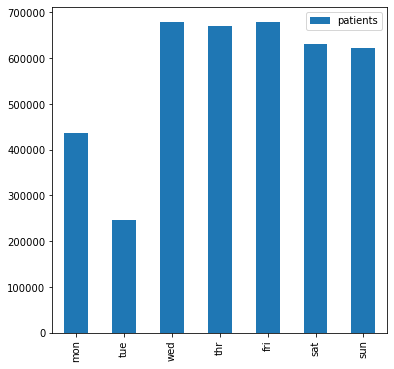

In [72]:
pd_week = week_fin.toPandas()
ax = pd_week[['patients']].plot(kind = 'bar', figsize = (6, 6))
ax.set_xticks([0, 1, 2, 3, 4, 5, 6])
ax.set_xticklabels(['mon', 'tue', 'wed', 'thr', 'fri', 'sat', 'sun'], rotation = 90)

- 요일별 신규 발생 환자 수 : dm db
- 매일 갱신